# R Analysis: figure generation
- Ruoyi Jiang
- April 27, 2019
- Using output from processing notebook, this notebook will replicate the figures related to BCR repertoire sequencing in [doi.org/10.4049/jimmunol.2100225](doi.org/10.4049/jimmunol.2100225)

# Before running
- Make sure that the processing notebook has been run to completion and there are no errors.
- Clone https://bitbucket.org/kleinstein/pipeline_abseq/src/master/ using git. This is provided with the docker image. 

# Define locations
- Please modify this part of the notebook before running to specify the following file and directory locations as needed.

-- PLOT_DIR : This is the location where figures should be output. Will be output to the directory of this notebook if not changed. 

-- META_FILE : This is the location of the meta data table for labelling samples.

-- DF_FILE : This is the result of the processing notebook. 

In [13]:
PLOT_DIR <- "/data/figures"
META_FILE <- "/git/projects/Jiang2021_JI/AIRR_BioSimple.csv"
DF_FILE <- "/data/bulk.tab"

# Load libraries

In [12]:
library(alakazam)
library(ggplot2)
library(RColorBrewer)
library(tidyverse)

source("/git/pipeline_abseq/api/saturn/saturn.R")

In [14]:
# Set up plotting parameters
PLOT_ORDER <- c("HD", "AChR", "MuSK")

DIAGNOSIS_COLORS <- c(
'AChR' = '#A6CEE3',
'HD' = '#979C62',
'MuSK' = '#FF7F00'
)

# Read in Changeo table and run more Changeo

In [16]:
identity_df <- read.csv(META_FILE) %>%
    rename(SAMPLE = Sample)

In [105]:
DF <- readChangeoDb(DF_FILE)

Warning message:
“Missing column names filled in: 'X1' [1]”Warning message:
“Missing column names filled in: 'X1' [1]”

In [7]:
DF_GERM <- DF %>%
    runCreateGermlines(cloned=FALSE)

[1] "CreateGermlines.py  -d /tmp/RtmpK2Yi5G/3aba713b1df1be.tab -r /home/ruoyi/kleinstein/reference/bulk/imgt/human/vdj -g dmask --format changeo --sf SEQUENCE_IMGT --vf V_CALL  --outdir /tmp/RtmpK2Yi5G"
[1] 0
[1] "/tmp/RtmpK2Yi5G/3aba713b1df1be_germ-pass.tab"


# Compute N-glyc frequencies

In [11]:
DF_GERM <- DF_GERM %>%
    mutate(FWR1_IMGT = extractVRegion(SEQUENCE_IMGT, "FWR1"),
           CDR1_IMGT = extractVRegion(SEQUENCE_IMGT, "CDR1"),
           FWR2_IMGT = extractVRegion(SEQUENCE_IMGT, "FWR2"),
           CDR2_IMGT = extractVRegion(SEQUENCE_IMGT, "CDR2"),
           FWR3_IMGT = extractVRegion(SEQUENCE_IMGT, "FWR3"),
          )

DF_GLYC <- DF_GERM %>%
    runCountGlycosylationRegions()

# Summarize N-glyc frequencies

In [122]:
DF_GLYC <- DF_GLYC %>%
    filter(FUNCTIONAL) %>%
    filter(CREGION == 'Human-IGHG-InternalC')

In [158]:
RESULT_DF <- DF_GLYC %>%
    select(SAMPLE, 
          GLYCOSYLATION_COUNT_V_SEQUENCE,
          GLYCOSYLATION_COUNT_V_GERMLINE,
          FWR1_IMGT_GLYC,
          CDR1_IMGT_GLYC,
          FWR2_IMGT_GLYC,
          CDR2_IMGT_GLYC,
          FWR3_IMGT_GLYC, 
          ) %>%
    gather("MEAN_SAMPLE", "VALUE", -SAMPLE) %>% 
    group_by(SAMPLE, MEAN_SAMPLE) %>%
    summarize(VALUE = mean(VALUE, na.rm=TRUE)) %>% 
    left_join(identity_df) %>%
    group_by(Patient.ID, Diagnosis, MEAN_SAMPLE) %>%
    summarize(VALUE = mean(VALUE)) %>%
    spread(MEAN_SAMPLE, VALUE) %>%
    mutate(Diagnosis = factor(Diagnosis, levels=PLOT_ORDER)) %>%
    ungroup()

`summarise()` regrouping output by 'SAMPLE' (override with `.groups` argument)
Joining, by = "SAMPLE"
`summarise()` regrouping output by 'Patient.ID', 'Diagnosis' (override with `.groups` argument)


In [222]:
RESULT_DF %>%
    write.csv(file.path(PLOT_DIR, "table_2.csv"))

# Plotting

In [223]:
RESULT_DF %>% 
    rename(MEAN = GLYCOSYLATION_COUNT_V_SEQUENCE) %>%
    group_by(Diagnosis) %>%
    summarize(MEAN = mean(MEAN))

`summarise()` ungrouping output (override with `.groups` argument)


Diagnosis MEAN      
1 HD        0.09799645
2 AChR      0.12341511
3 MuSK      0.16827437

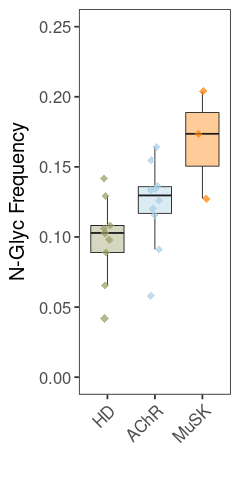

In [203]:
options(repr.plot.width=2, repr.plot.height=4)

m2 <- RESULT_DF %>% 
    rename(MEAN = GLYCOSYLATION_COUNT_V_SEQUENCE) %>% 
    ggplot(aes(x=Diagnosis, y=MEAN)) +
    baseTheme() +
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle = 45, hjust = 1, vjust = 1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=8), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("") +
    ylab(expression("N-Glyc Frequency")) +
    scale_y_continuous(limits = c(0,0.25)) +
    scale_fill_manual(values=DIAGNOSIS_COLORS, name="Diagnosis") +
    scale_color_manual(values=DIAGNOSIS_COLORS, name="Diagnosis") +
    geom_boxplot(aes(fill=Diagnosis), position=position_dodge(0.8), width=0.7, size=0.25,
                color="grey10", outlier.colour=NA, alpha=0.4) +
    geom_point(aes(color=Diagnosis), position=position_jitter(w = 0.1, h = 0), size=2, pch=18, alpha=0.7)
plot(m2)

In [204]:
plotFigure(m2, file.path(PLOT_DIR, "igg_nglyc_sequence.pdf"), width=2, height=4)

png 
  2

In [206]:
wilcox.test(
    RESULT_DF %>% 
    rename(MEAN = GLYCOSYLATION_COUNT_V_SEQUENCE) %>%
    filter(Diagnosis == "AChR") %>% 
    select(MEAN) %>% unlist(),
    RESULT_DF %>% 
    rename(MEAN = GLYCOSYLATION_COUNT_V_SEQUENCE) %>%
    filter(Diagnosis == "HD") %>% 
    select(MEAN) %>% unlist(),
    alternative="greater"
)


	Wilcoxon rank sum test

data:  RESULT_DF %>% rename(MEAN = GLYCOSYLATION_COUNT_V_SEQUENCE) %>%  and RESULT_DF %>% rename(MEAN = GLYCOSYLATION_COUNT_V_SEQUENCE) %>%     filter(Diagnosis == "AChR") %>% select(MEAN) %>% unlist() and     filter(Diagnosis == "HD") %>% select(MEAN) %>% unlist()
W = 67, p-value = 0.03945
alternative hypothesis: true location shift is greater than 0


In [207]:
wilcox.test(
    RESULT_DF %>% 
    rename(MEAN = GLYCOSYLATION_COUNT_V_SEQUENCE) %>%
    filter(Diagnosis == "MuSK") %>% 
    select(MEAN) %>% unlist(),
    RESULT_DF %>% 
    rename(MEAN = GLYCOSYLATION_COUNT_V_SEQUENCE) %>%
    filter(Diagnosis == "HD") %>% 
    select(MEAN) %>% unlist(),
    alternative="greater"
)


	Wilcoxon rank sum test

data:  RESULT_DF %>% rename(MEAN = GLYCOSYLATION_COUNT_V_SEQUENCE) %>%  and RESULT_DF %>% rename(MEAN = GLYCOSYLATION_COUNT_V_SEQUENCE) %>%     filter(Diagnosis == "MuSK") %>% select(MEAN) %>% unlist() and     filter(Diagnosis == "HD") %>% select(MEAN) %>% unlist()
W = 25, p-value = 0.01818
alternative hypothesis: true location shift is greater than 0


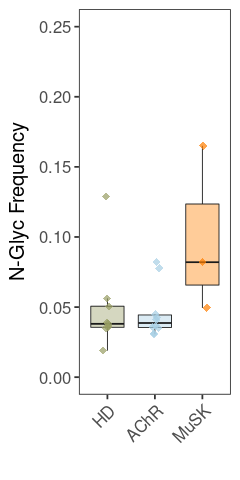

In [208]:
options(repr.plot.width=2, repr.plot.height=4)

m2 <- RESULT_DF %>% 
    rename(MEAN = GLYCOSYLATION_COUNT_V_GERMLINE) %>% 
    ggplot(aes(x=Diagnosis, y=MEAN)) +
    baseTheme() +
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle = 45, hjust = 1, vjust = 1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=8), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("") +
    ylab(expression("N-Glyc Frequency")) +
    scale_y_continuous(limits = c(0,0.25)) +
    scale_fill_manual(values=DIAGNOSIS_COLORS, name="Diagnosis") +
    scale_color_manual(values=DIAGNOSIS_COLORS, name="Diagnosis") +
    geom_boxplot(aes(fill=Diagnosis), position=position_dodge(0.8), width=0.7, size=0.25,
                color="grey10", outlier.colour=NA, alpha=0.4) +
    geom_point(aes(color=Diagnosis), position=position_jitter(w = 0.1, h = 0), size=2, pch=18, alpha=0.7)
plot(m2)

In [209]:
plotFigure(m2, file.path(PLOT_DIR, "igg_nglyc_germline.pdf"), width=2, height=4)

png 
  2

In [211]:
wilcox.test(
    RESULT_DF %>% 
    rename(MEAN = GLYCOSYLATION_COUNT_V_GERMLINE) %>%
    filter(Diagnosis == "AChR") %>% 
    select(MEAN) %>% unlist(),
    RESULT_DF %>% 
    rename(MEAN = GLYCOSYLATION_COUNT_V_GERMLINE) %>%
    filter(Diagnosis == "HD") %>% 
    select(MEAN) %>% unlist(),
    alternative="greater"
)


	Wilcoxon rank sum test

data:  RESULT_DF %>% rename(MEAN = GLYCOSYLATION_COUNT_V_GERMLINE) %>%  and RESULT_DF %>% rename(MEAN = GLYCOSYLATION_COUNT_V_GERMLINE) %>%     filter(Diagnosis == "AChR") %>% select(MEAN) %>% unlist() and     filter(Diagnosis == "HD") %>% select(MEAN) %>% unlist()
W = 44, p-value = 0.5476
alternative hypothesis: true location shift is greater than 0


In [212]:
wilcox.test(
    RESULT_DF %>% 
    rename(MEAN = GLYCOSYLATION_COUNT_V_GERMLINE) %>%
    filter(Diagnosis == "MuSK") %>% 
    select(MEAN) %>% unlist(),
    RESULT_DF %>% 
    rename(MEAN = GLYCOSYLATION_COUNT_V_GERMLINE) %>%
    filter(Diagnosis == "HD") %>% 
    select(MEAN) %>% unlist(),
    alternative="greater"
)


	Wilcoxon rank sum test

data:  RESULT_DF %>% rename(MEAN = GLYCOSYLATION_COUNT_V_GERMLINE) %>%  and RESULT_DF %>% rename(MEAN = GLYCOSYLATION_COUNT_V_GERMLINE) %>%     filter(Diagnosis == "MuSK") %>% select(MEAN) %>% unlist() and     filter(Diagnosis == "HD") %>% select(MEAN) %>% unlist()
W = 23, p-value = 0.05
alternative hypothesis: true location shift is greater than 0


# Plotting regions

In [213]:
region_fields <- c('FWR1_IMGT_GLYC', 
                   'CDR1_IMGT_GLYC', 
                   'FWR2_IMGT_GLYC',
                   'CDR2_IMGT_GLYC', 
                   'FWR3_IMGT_GLYC')

In [214]:
formal_fields <- c('FWR1', 
            'CDR1', 
            'FWR2', 
            'CDR2', 
            'FWR3')

In [215]:
region_fields -> names(formal_fields)

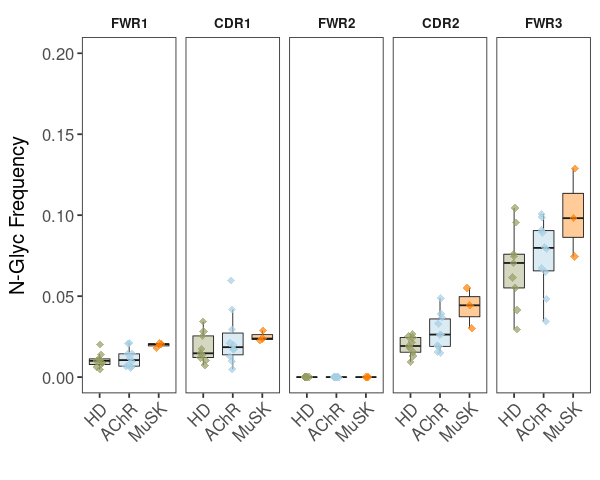

In [220]:
options(repr.plot.width=5, repr.plot.height=4)
plot_tab <- RESULT_DF %>%
    select(Patient.ID, Diagnosis, !!!rlang::syms(region_fields)) %>%
    gather(FIELD, VALUE, -Patient.ID, -Diagnosis) %>%
    mutate(FIELD = formal_fields[FIELD], FIELD = factor(FIELD, levels=formal_fields)) 
    
m2 <- plot_tab %>%
    ggplot(aes(x=Diagnosis, y=VALUE)) +
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle = 45, hjust = 1, vjust = 1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=8), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("") +
    ylab(expression("N-Glyc Frequency")) +
    scale_y_continuous(limits=c(0,0.2)) +
    scale_fill_manual(values=DIAGNOSIS_COLORS, name="Status") +
    scale_color_manual(values=DIAGNOSIS_COLORS, name="Status") +
    geom_boxplot(aes(fill=Diagnosis), position=position_dodge(0.8), width=0.7, size=0.25,
                color="grey10", outlier.colour=NA, alpha=0.4) +
    geom_point(aes(color=Diagnosis), position=position_jitter(w = 0.1, h = 0), size=2, pch=18, alpha=0.7) +
    facet_grid(. ~ FIELD)
plot(m2)

In [221]:
plotFigure(m2, file.path(PLOT_DIR, "igg_nglyc_regions.pdf"), width=5, height=4)

png 
  2

In [218]:
for(field in formal_fields){
    print(field)
    wilcox.test(filter(plot_tab, Diagnosis == "AChR", FIELD == field)$VALUE,
       filter(plot_tab, Diagnosis == "HD", FIELD == field)$VALUE, alternative = "greater") %>% print()
}

[1] "FWR1"

	Wilcoxon rank sum test

data:  filter(plot_tab, Diagnosis == "AChR", FIELD == field)$VALUE and filter(plot_tab, Diagnosis == "HD", FIELD == field)$VALUE
W = 52, p-value = 0.3019
alternative hypothesis: true location shift is greater than 0

[1] "CDR1"

	Wilcoxon rank sum test

data:  filter(plot_tab, Diagnosis == "AChR", FIELD == field)$VALUE and filter(plot_tab, Diagnosis == "HD", FIELD == field)$VALUE
W = 52, p-value = 0.3019
alternative hypothesis: true location shift is greater than 0

[1] "FWR2"


Warning message in wilcox.test.default(filter(plot_tab, Diagnosis == "AChR", FIELD == :
“cannot compute exact p-value with ties”


	Wilcoxon rank sum test with continuity correction

data:  filter(plot_tab, Diagnosis == "AChR", FIELD == field)$VALUE and filter(plot_tab, Diagnosis == "HD", FIELD == field)$VALUE
W = 40, p-value = 0.8769
alternative hypothesis: true location shift is greater than 0

[1] "CDR2"

	Wilcoxon rank sum test

data:  filter(plot_tab, Diagnosis == "AChR", FIELD == field)$VALUE and filter(plot_tab, Diagnosis == "HD", FIELD == field)$VALUE
W = 66, p-value = 0.04736
alternative hypothesis: true location shift is greater than 0

[1] "FWR3"

	Wilcoxon rank sum test

data:  filter(plot_tab, Diagnosis == "AChR", FIELD == field)$VALUE and filter(plot_tab, Diagnosis == "HD", FIELD == field)$VALUE
W = 55, p-value = 0.2235
alternative hypothesis: true location shift is greater than 0



In [219]:
for(field in formal_fields){
    print(field)
    wilcox.test(filter(plot_tab, Diagnosis == "MuSK", FIELD == field)$VALUE,
       filter(plot_tab, Diagnosis == "HD", FIELD == field)$VALUE, alternative = "greater") %>% print()
}

[1] "FWR1"

	Wilcoxon rank sum test

data:  filter(plot_tab, Diagnosis == "MuSK", FIELD == field)$VALUE and filter(plot_tab, Diagnosis == "HD", FIELD == field)$VALUE
W = 26, p-value = 0.009091
alternative hypothesis: true location shift is greater than 0

[1] "CDR1"

	Wilcoxon rank sum test

data:  filter(plot_tab, Diagnosis == "MuSK", FIELD == field)$VALUE and filter(plot_tab, Diagnosis == "HD", FIELD == field)$VALUE
W = 20, p-value = 0.1409
alternative hypothesis: true location shift is greater than 0

[1] "FWR2"


Warning message in wilcox.test.default(filter(plot_tab, Diagnosis == "MuSK", FIELD == :
“cannot compute exact p-value with ties”


	Wilcoxon rank sum test with continuity correction

data:  filter(plot_tab, Diagnosis == "MuSK", FIELD == field)$VALUE and filter(plot_tab, Diagnosis == "HD", FIELD == field)$VALUE
W = 16, p-value = 0.2848
alternative hypothesis: true location shift is greater than 0

[1] "CDR2"

	Wilcoxon rank sum test

data:  filter(plot_tab, Diagnosis == "MuSK", FIELD == field)$VALUE and filter(plot_tab, Diagnosis == "HD", FIELD == field)$VALUE
W = 27, p-value = 0.004545
alternative hypothesis: true location shift is greater than 0

[1] "FWR3"

	Wilcoxon rank sum test

data:  filter(plot_tab, Diagnosis == "MuSK", FIELD == field)$VALUE and filter(plot_tab, Diagnosis == "HD", FIELD == field)$VALUE
W = 22, p-value = 0.07273
alternative hypothesis: true location shift is greater than 0

